In [48]:
import torch as t
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision as tv
from torch.utils.data import DataLoader
from tqdm import tqdm 
from matplotlib.pyplot import *

In [2]:
transform=tv.transforms.transforms.ToTensor()
train_data=tv.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_data=tv.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

In [3]:
trainloader=DataLoader(train_data, batch_size=64, shuffle=True)
testloader=DataLoader(test_data, batch_size=64, shuffle=False)

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride = 1, padding=1)  # (in_channels, output_channels, kernel_size, padding)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride = 1, padding=1) 
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.fc1 = nn.Linear(7 * 7 * 64, 128)  
        self.fc2 = nn.Linear(128, 10) 
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # Conv1 -> ReLU -> Pool: (64,  1, 28, 28) -> (64, 32, 14, 14) 
        x = self.pool(self.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pool: (64, 32, 14, 14) -> (64, 64,  7,  7)
        x = x.flatten(start_dim=1)  # (64, 64 * 7 * 7)
        x = self.relu(self.fc1(x))  # FC1 -> ReLU
        x = self.fc2(x)  # FC2 (Output)
        return x


t.mps.empty_cache()

device = t.device("mps")
model = CNN().to(device)

# 4️⃣ Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 5️⃣ Training Loop
num_epochs = 5
batch_loss=[]
loss_buffer=0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    n=1

    
    pgbar=tqdm(trainloader, desc=f"Epoch{epoch+1}/{num_epochs}", leave=True, dynamic_ncols=True) 

    for batch_idx, (images, labels) in enumerate(pgbar):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Reset gradients
        outputs = model(images) 
        loss = criterion(outputs, labels) 
        loss.backward()  # compute gradient
        optimizer.step() 
        
        running_loss += loss.item()
        loss_buffer += loss.item()

        if n % len(images) == 0:
            batch_loss.append(loss_buffer)
            loss_buffer=0
        pgbar.set_postfix({'loss': f'{loss.item():.4f}'})
        n+=1

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(trainloader):.4f}")


Epoch1/5: 100%|██████████| 938/938 [00:38<00:00, 24.32it/s, loss=0.1225]


Epoch 1/5, Loss: 0.1816


Epoch2/5: 100%|██████████| 938/938 [00:35<00:00, 26.38it/s, loss=0.0421]


Epoch 2/5, Loss: 0.0530


Epoch3/5: 100%|██████████| 938/938 [00:34<00:00, 26.93it/s, loss=0.0144]


Epoch 3/5, Loss: 0.0360


Epoch4/5: 100%|██████████| 938/938 [00:34<00:00, 27.14it/s, loss=0.0009]


Epoch 4/5, Loss: 0.0269


Epoch5/5: 100%|██████████| 938/938 [00:37<00:00, 24.75it/s, loss=0.0023]

Epoch 5/5, Loss: 0.0205


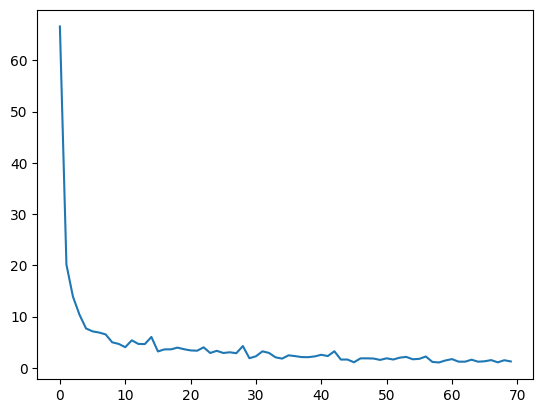

In [19]:
plot(range(len(trainloader)//64*5), batch_loss);

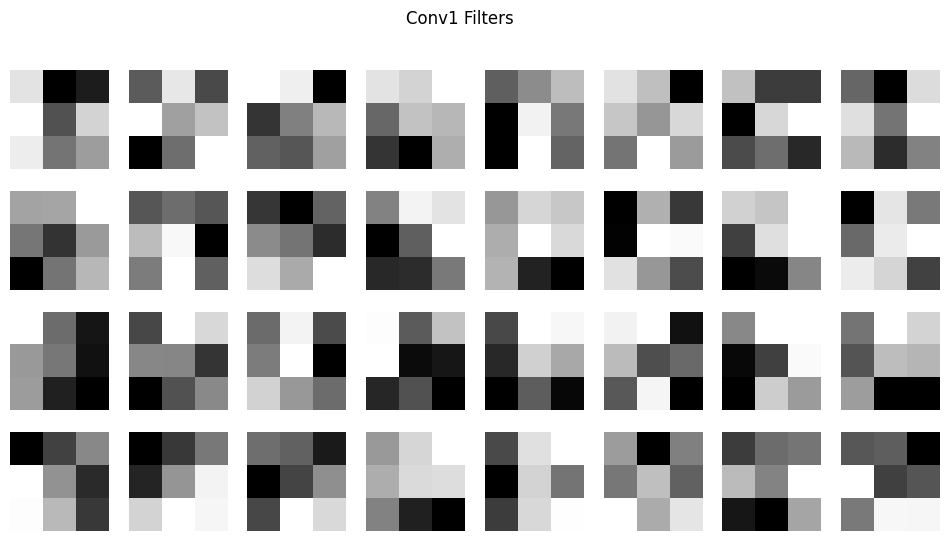

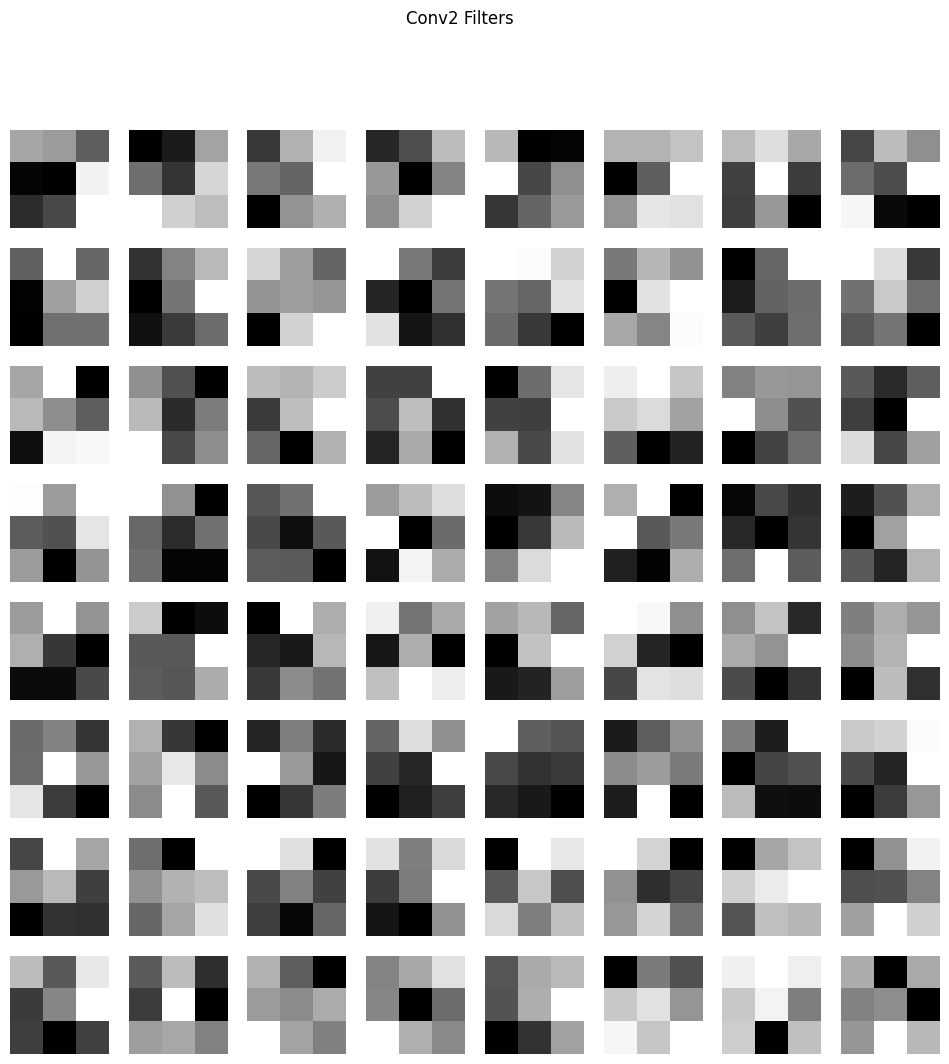

In [37]:
C1_filters = model.conv1.weight.data.clone()
C1_filters.shape
num_filters = C1_filters.shape[0]
fig, axes = subplots(4, 8, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    if i < num_filters:
        # Remove the channel dimension (only one channel) for plotting
        filter_img = C1_filters[i, 0, :, :].cpu().numpy()
        ax.imshow(filter_img, cmap='gray')
    ax.axis('off')
suptitle("Conv1 Filters")

C2_filters = model.conv2.weight.data.clone()
C2_filters.shape
num_filters = C2_filters.shape[0]
fig, axes = subplots(8, 8, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    if i < num_filters:
        # Remove the channel dimension (only one channel) for plotting
        filter_img = C2_filters[i, 0, :, :].cpu().numpy()
        ax.imshow(filter_img, cmap='gray')
    ax.axis('off')
suptitle("Conv2 Filters")
show()

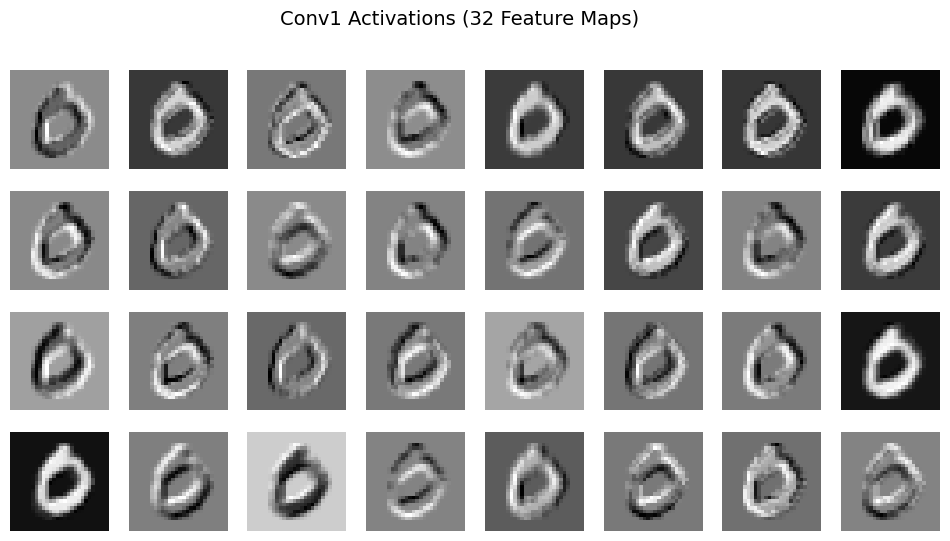

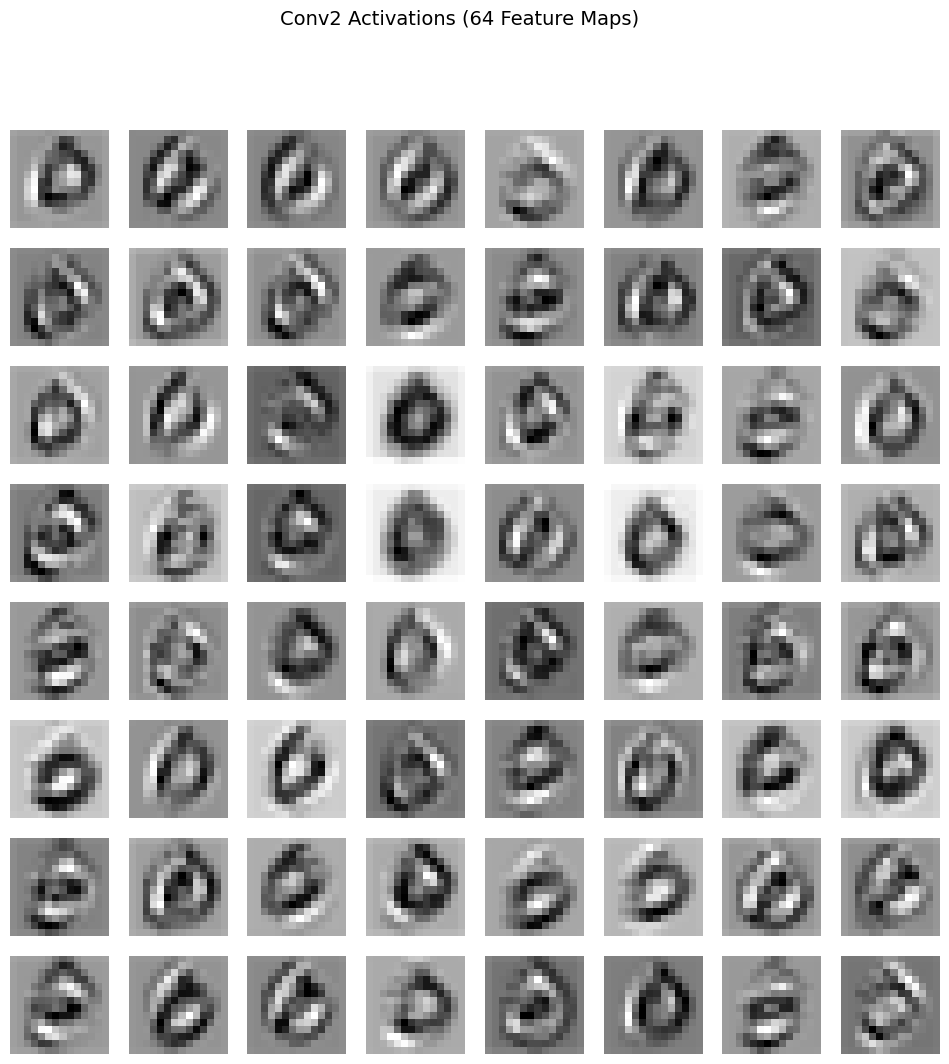

tensor([[9.9995e-01, 1.4133e-08, 5.5768e-10, 1.2985e-09, 1.3120e-08, 2.1513e-07,
         3.5776e-05, 6.4658e-06, 2.2978e-07, 4.1001e-06]], device='mps:0',
       grad_fn=<SoftmaxBackward0>)


/var/folders/2m/wmhx4p3j2nl2tb_z521x4qwr0000gn/T/ipykernel_51642/3825986466.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(F.softmax(prediction))


In [51]:
image, label = test_data[3]
image = image.unsqueeze(0).to(device)

activations = {}

def hook_fn(name):
    def hook(module, input, output):
        activations[name] = output  # Save layer activations
    return hook

# Register hooks for conv1 and conv2
hook1 = model.conv1.register_forward_hook(hook_fn('conv1'))
hook2 = model.conv2.register_forward_hook(hook_fn('conv2'))

# Pass the image through the model
prediction = model(image) 

# Remove hooks (cleanup)
hook1.remove()
hook2.remove()

# Get conv1 and conv2 activations
conv1_output = activations['conv1'].cpu().detach().squeeze(0)  # Shape: (32, 28, 28)
conv2_output = activations['conv2'].cpu().detach().squeeze(0)  # Shape: (64, 14, 14)

# Plot feature maps for conv1
fig, axes = subplots(4, 8, figsize=(12, 6))
fig.suptitle("Conv1 Activations (32 Feature Maps)", fontsize=14)

for i, ax in enumerate(axes.flat):
    if i < conv1_output.shape[0]:  # Only plot valid channels
        ax.imshow(conv1_output[i], cmap="gray")  # Plot feature map
        ax.axis("off")

show()

# Plot feature maps for conv2
fig, axes =subplots(8, 8, figsize=(12, 12))
fig.suptitle("Conv2 Activations (64 Feature Maps)", fontsize=14)

for i, ax in enumerate(axes.flat):
    if i < conv2_output.shape[0]:  # Only plot valid channels
        ax.imshow(conv2_output[i], cmap="gray")  # Plot feature map
        ax.axis("off")

show()

print(F.softmax(prediction))

In [26]:
model.eval()
correct = 0
total = 0
with t.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = t.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 99.06%


In [70]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1=nn.Linear(784, 256)
        self.fc2=nn.Linear(256,128)
        self.fc3=nn.Linear(128,10)
        self.relu=nn.ReLU()

    def forward(self, x):
        x = x.flatten(start_dim=1)
        h1 = self.relu(self.fc1(x))  
        h2 = self.relu(self.fc2(h1))
        y=self.fc3(h2)
        return y



t.mps.empty_cache()



MLP=MLP().to(device)

num_epochs=6
batch_loss=[]
loss_buffer=0

for epoch in range(num_epochs):

    pgbar=tqdm(trainloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True) 
    criterion=nn.CrossEntropyLoss()
    optimizer=t.optim.Adam(MLP.parameters(), lr=0.001) ################################
    running_loss=0.0
    n=1

    for batch_idx, (images, labels) in enumerate(pgbar):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()            #####################################################
        y=MLP(images)
        loss=criterion(y, labels)
        loss.backward()          ########################################################
        optimizer.step()
        
        running_loss+=loss.item()
        loss_buffer+=loss.item()

        if n % len(images) ==0:
            batch_loss.append(loss_buffer)
            loss_buffer=0
        pgbar.set_postfix({'loss': f'{loss.item():.4f}'})
        n+=1

    print(f"Loss: {running_loss / len(trainloader):.4f}")

Epoch 1/6: 100%|██████████| 938/938 [00:27<00:00, 33.95it/s, loss=0.1658]


Loss: 0.2816


Epoch 2/6: 100%|██████████| 938/938 [00:29<00:00, 31.33it/s, loss=0.0814]


Loss: 0.1086


Epoch 3/6: 100%|██████████| 938/938 [00:28<00:00, 33.46it/s, loss=0.0270]


Loss: 0.0729


Epoch 4/6: 100%|██████████| 938/938 [00:35<00:00, 26.39it/s, loss=0.0166]


Loss: 0.0522


Epoch 5/6: 100%|██████████| 938/938 [00:39<00:00, 23.91it/s, loss=0.0018]


Loss: 0.0408


Epoch 6/6: 100%|██████████| 938/938 [00:38<00:00, 24.24it/s, loss=0.0035]

Loss: 0.0324


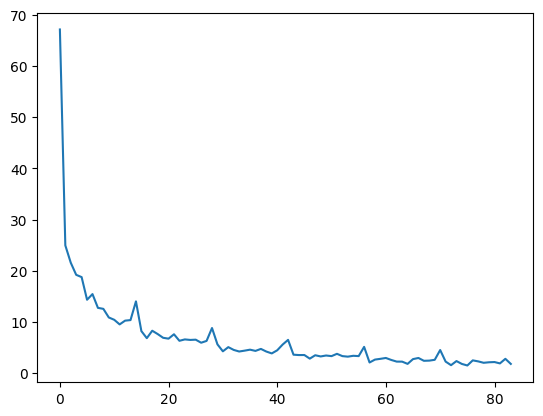

In [72]:
plot(range(len(trainloader)//64*6), batch_loss);

In [73]:
MLP.eval()
correct = 0
total = 0
with t.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = MLP(images)
        _, predicted = t.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 97.93%


torch.Size([256, 784])


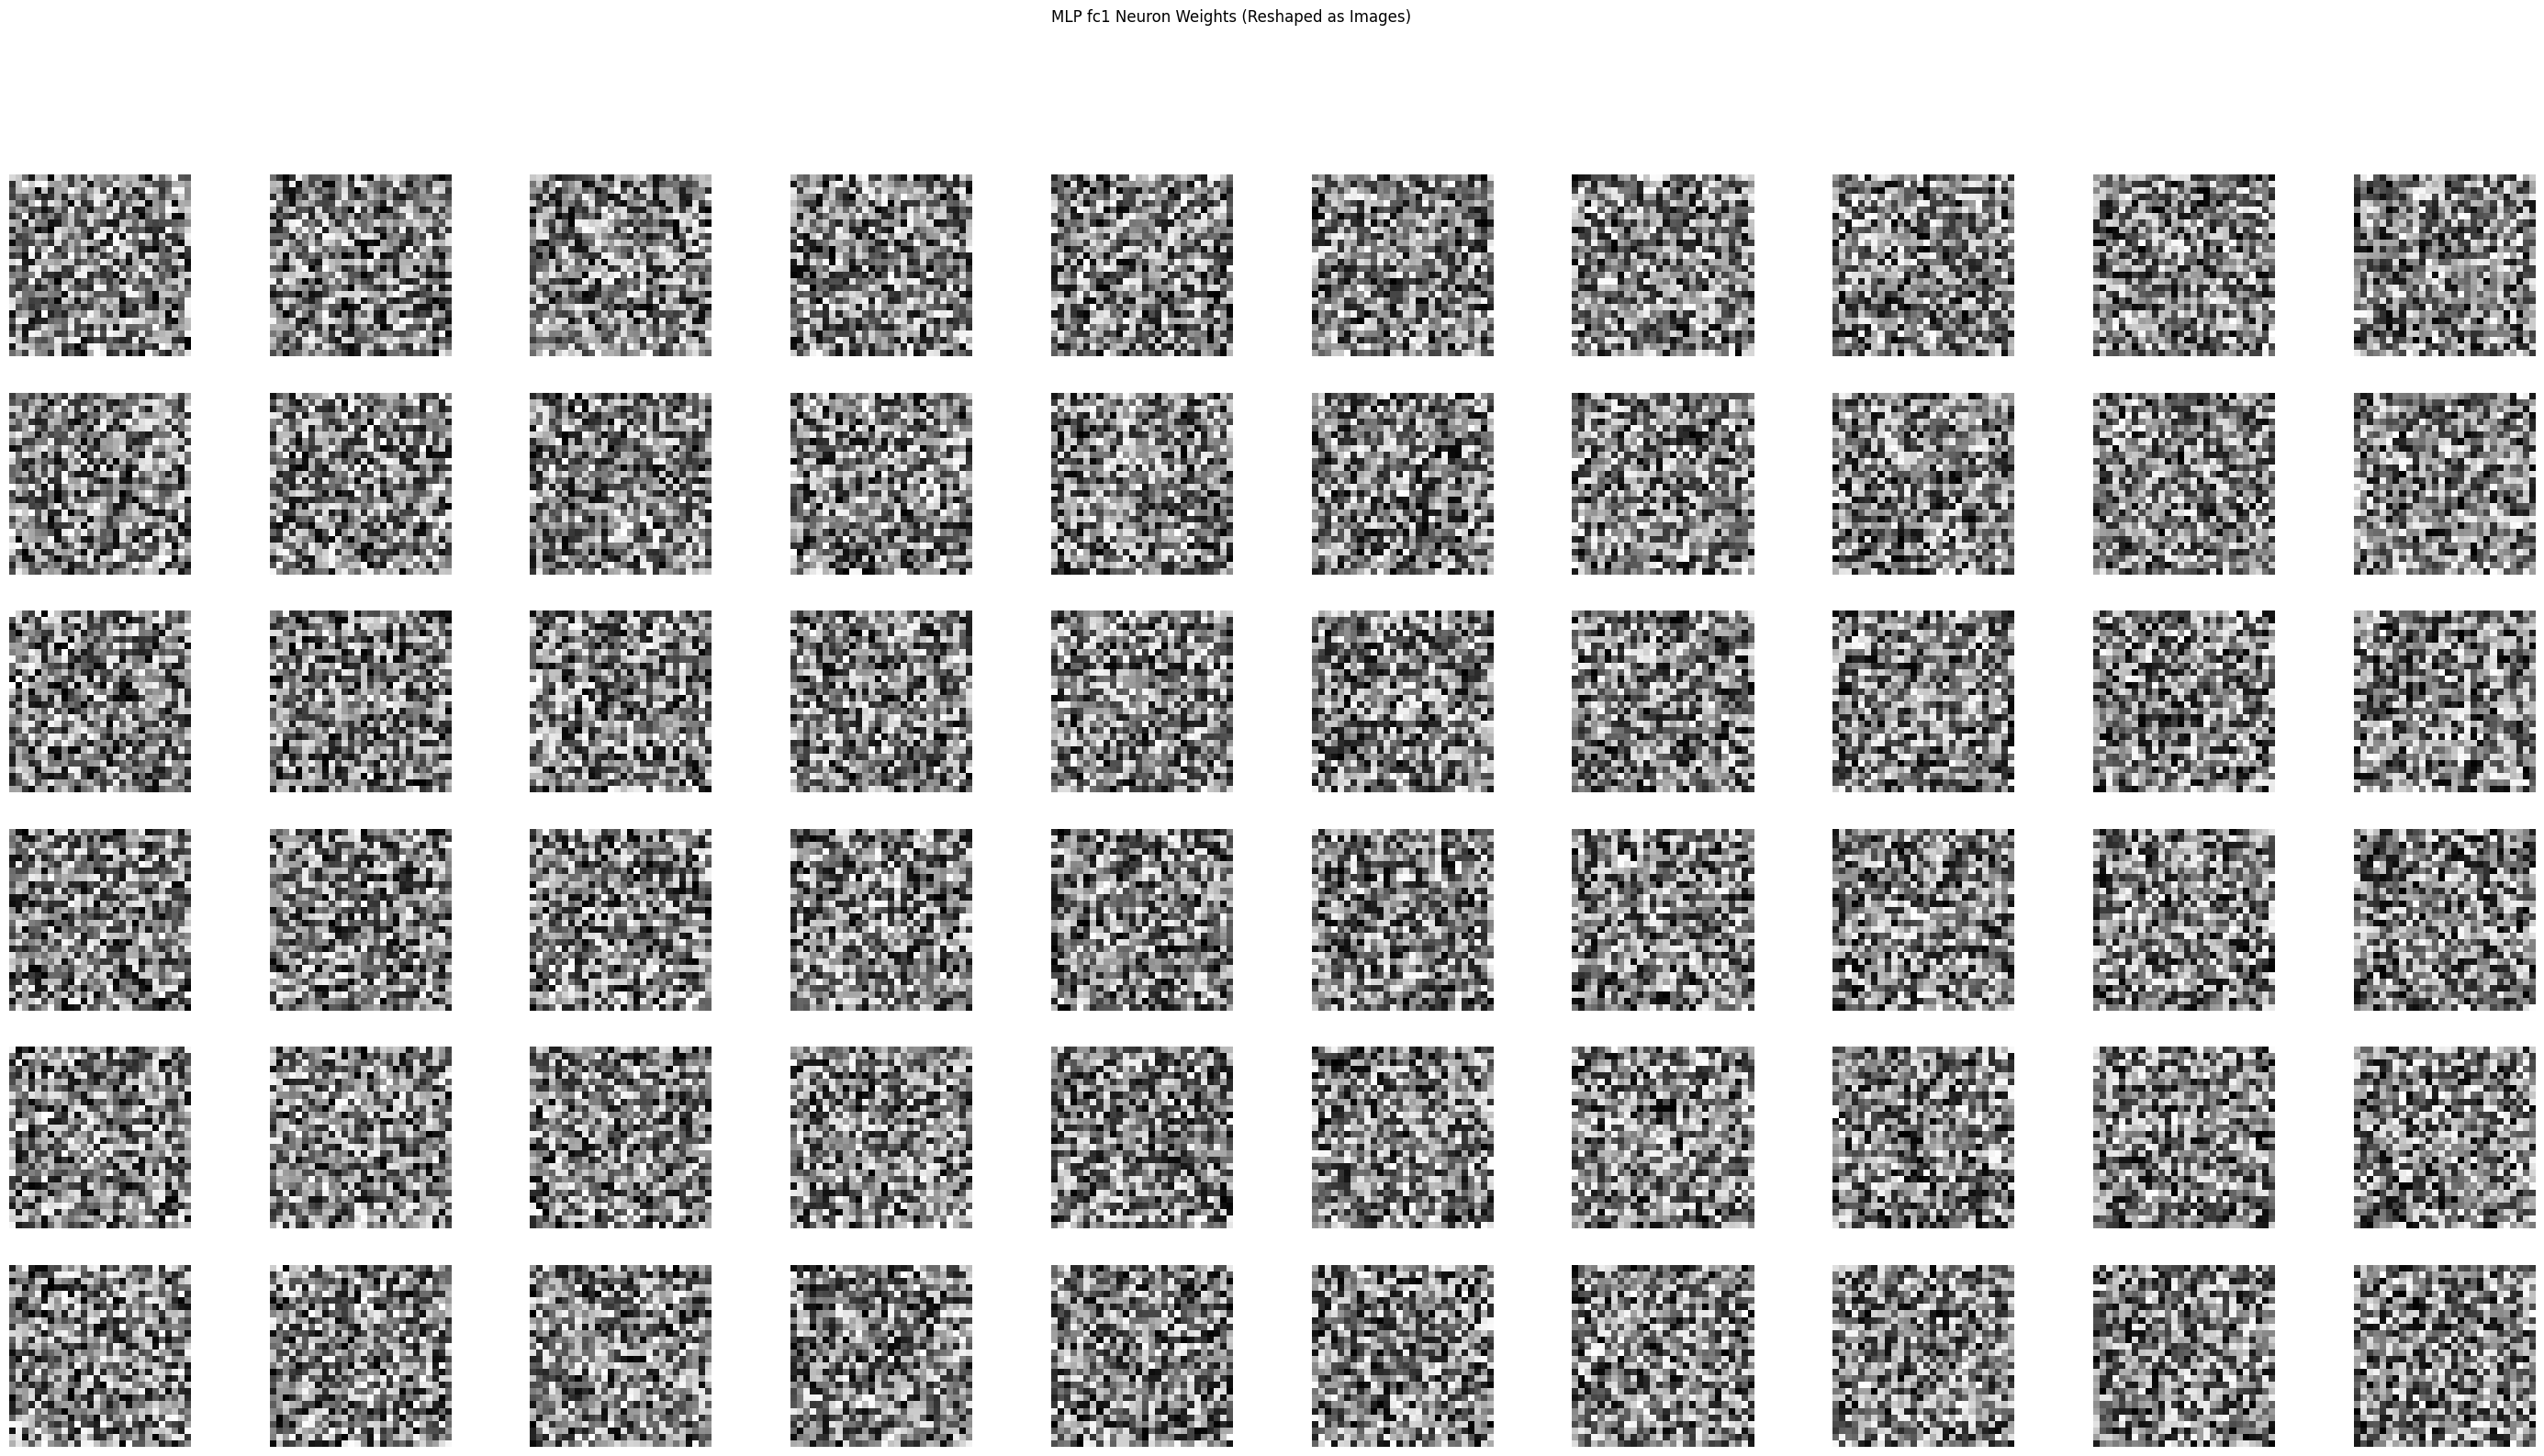

In [98]:
# Get fc1 weights
fc1_weights = model.fc1.weight.data.clone()  # Shape: (256, 784)
print(fc1_weights.shape)

# Reshape each neuron's weights into 28×28 (like an image)
fc1_images = fc1_weights.view(256, 28, 28).cpu().numpy()  # Shape: (256, 28, 28)

# Plot some neurons' weights as heatmaps
num_neurons = 64  # Number of neurons to visualize (out of 256)
fig, axes = subplots(6, 10, figsize=(36, 18))

for i, ax in enumerate(axes.flat):
    if i < num_neurons:
        ax.imshow(fc1_images[i], cmap='gray')  # Plot weights of each neuron as 28×28 heatmaps
    ax.axis('off')

suptitle("MLP fc1 Neuron Weights (Reshaped as Images)")
show();


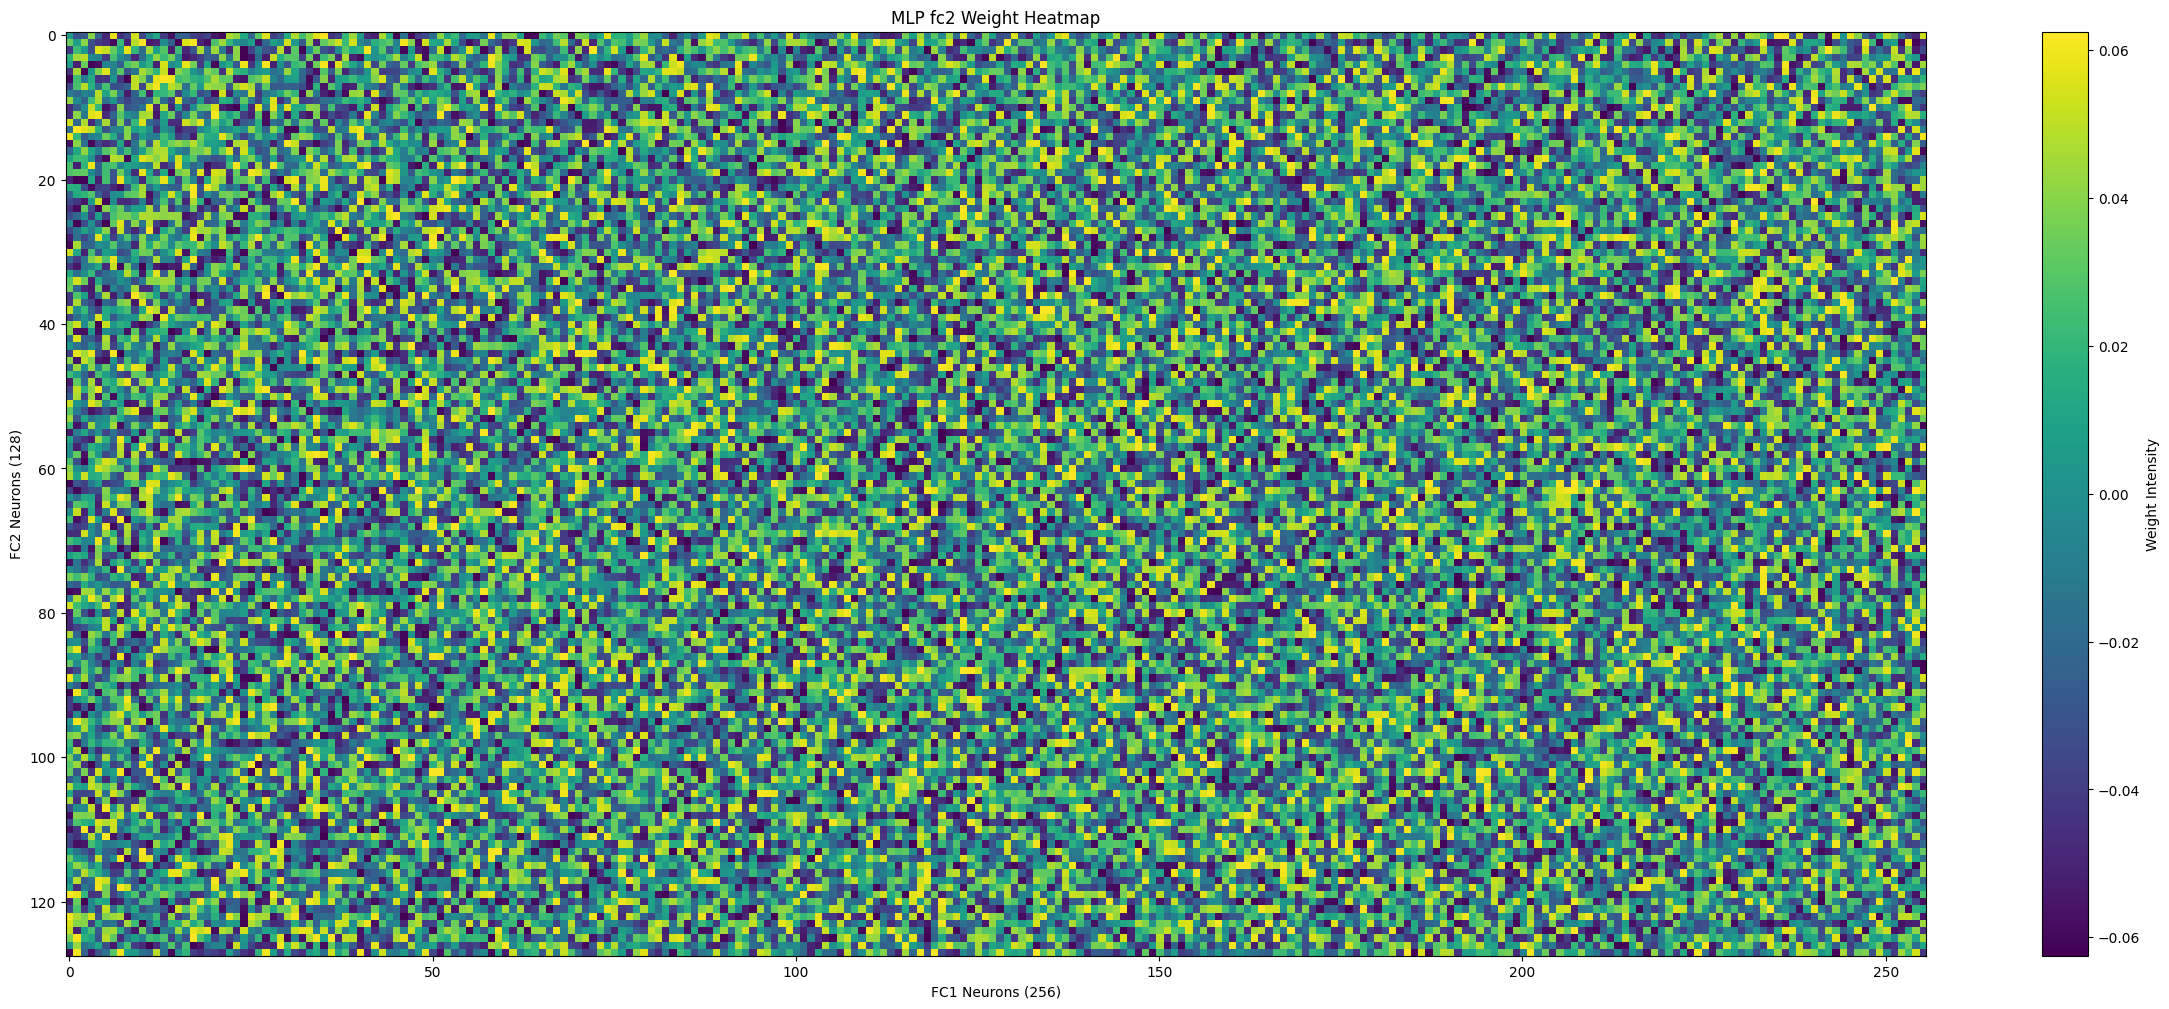

In [93]:
# Get fc2 weights
fc2_weights = model.fc2.weight.data.clone().cpu().numpy()  # Shape: (128, 256)

# Create a heatmap
figure(figsize=(30, 12))
imshow(fc2_weights, cmap="viridis", aspect="auto")
colorbar(label="Weight Intensity")
xlabel("FC1 Neurons (256)")
ylabel("FC2 Neurons (128)")
title("MLP fc2 Weight Heatmap")
show()


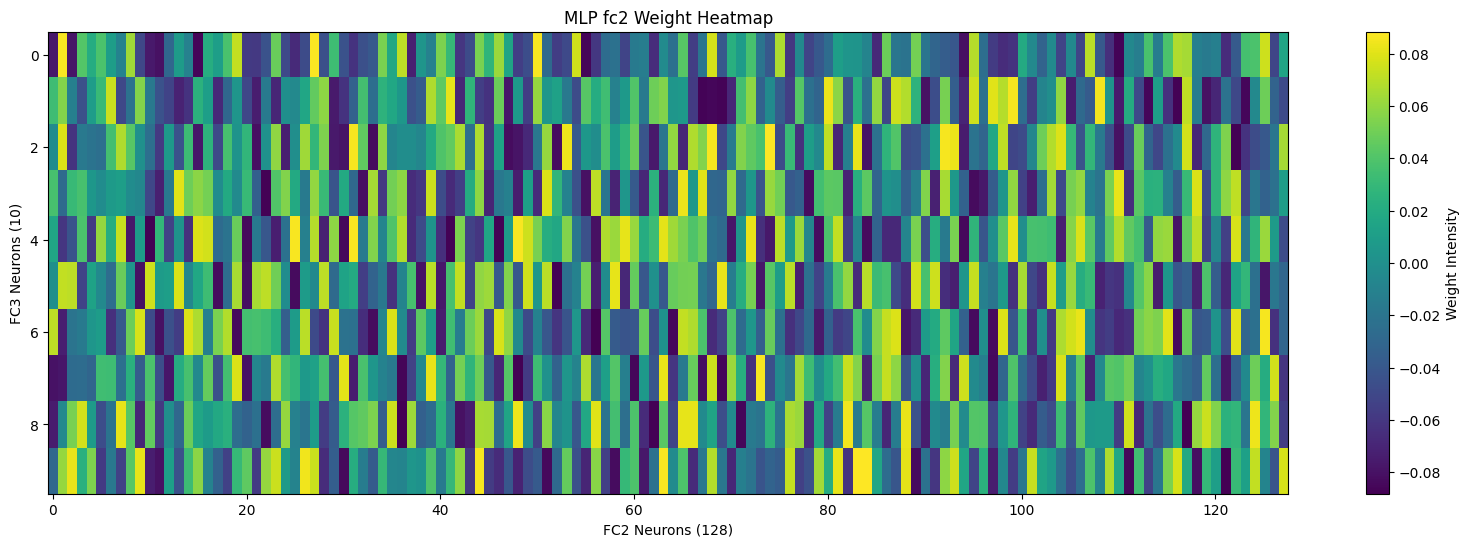

In [90]:
# Get fc2 weights
fc3_weights = model.fc3.weight.data.clone().cpu().numpy()  

# Create a heatmap
figure(figsize=(20, 6))
imshow(fc3_weights, cmap="viridis", aspect="auto")
colorbar(label="Weight Intensity")
xlabel("FC2 Neurons (128)")
ylabel("FC3 Neurons (10)")
title("MLP fc2 Weight Heatmap")
show()